### K-Nearest Neighbor Classifier

#### The K-Nearest Neighbor (KNN) classifier is a very simple learning method but performs remarkably well considering its simple approach. To predict a classification using KNN we identify the K nearest points from the training set and then assign the new point to the class having the largest number of representatives amongst this set.
#### In the nearest neighbor K = 1 classification case, the decision boundary is composed of hyperplanes that form perpendicular bisectors of pairs of points from different classes. This case is known as the $nearest-neighbor \space rule$ because a test point is simply assigned to the same class as the nearest point in the training set.
   
<img style="float: l;" src="./images/knn.png" width="500px">   

$$
\begin{aligned}
KNN\space is\space prone\space to\space both\space overfitting\space our\space data\space if\space K\space is\space too\space small\space and\space underfitting\space our\space data\space if\space K\space is\space too\space large.
\end{aligned}
$$

<BR>

<img align="center" style="float: l;" src="./images/distance-measures.png" width="500px">



                                           
### Environment Setup

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
%matplotlib inline 
import matplotlib.pyplot as plt

### Syntatic NLP Processing

#### We will define some Python functions that will perform some syntatic work on our corpus. 

In [2]:
def tokenize(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [ token for token in tokens if re.search('(^[a-zA-Z]+$)', token) ]
    return filtered_tokens

cachedStopWords = stopwords.words("english")
noisywords = ['year', 'old', 'man', 'woman', 'ap', 'am', 'pm', 'portable', 'pa', 'lat', 'admitting', 'diagnosis', 'lateral']
cachedStopWords.extend(noisywords)
print(cachedStopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Retrieving our Corpus

#### Let's pull in our corpus that we had serialized out to disk.  

In [4]:
file = open('differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()
corpusList = list(corpus['text'].tolist())
labels = list(corpus['label'].tolist())
corpus.head()

,text,label
0,[**2996-12-2**] 10:25 AM\n CT CHEST W/O CONTRA...,PNA
1,[**3201-9-21**] 4:50 PM\n CT CHEST W/CONTRAST ...,PNA
2,[**3299-6-23**] 5:06 PM\n CT CHEST W/CONTRAST ...,PNA
3,[**3186-6-14**] 2:54 PM\n CT CHEST W/CONTRAST ...,PNA
4,[**2500-1-17**] 9:41 PM\n CT CHEST W/O CONTRAS...,PNA


### Generate Document-Term Frequency Counts

#### In this step we tokenize our text and remove stop words in addition to generating our frequency counts.

#### 1) How many documents are we working with and how many features (unigrams & bigrams)?

#### 2) Can you figure out what max_df and min_df is doing to our feature count?

In [5]:
#cv = CountVectorizer(lowercase=True, max_df=0.90, max_features=None, min_df=0.033,
#                     ngram_range=(1, 2), preprocessor=None, stop_words=cachedStopWords,
#                     strip_accents=None, tokenizer=tokenize, vocabulary=None)
cv = TfidfVectorizer(lowercase=True, max_df=0.90, max_features=None, min_df=0.033,
                     ngram_range=(1, 2), preprocessor=None, stop_words=cachedStopWords,
                     strip_accents=None, tokenizer=tokenize, vocabulary=None)
X = cv.fit_transform(corpusList)
print(X.shape)
print()
lexicon = cv.get_feature_names()
print (lexicon)
print()

D:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(1500, 920)

['abdomen', 'abdomen pelvis', 'abdominal', 'abnormalities', 'abnormality', 'acquired', 'acute', 'addition', 'additional', 'additionally', 'adenopathy', 'adjacent', 'administered', 'administration', 'administration cc', 'administration iv', 'admitted', 'adrenal', 'adrenal glands', 'air', 'air bronchograms', 'airspace', 'airways', 'airways patent', 'allowing', 'along', 'also', 'also noted', 'although', 'alveolar', 'amount', 'amt', 'amt final', 'amt underlying', 'angle', 'anterior', 'aorta', 'aortic', 'apex', 'apical', 'apices', 'appear', 'appearance', 'appears', 'appropriate', 'approximately', 'approximately cm', 'arch', 'area', 'areas', 'areas consolidation', 'arterial', 'arteries', 'artery', 'artery calcifications', 'ascites', 'aspect', 'aspiration', 'assess', 'assessment', 'associated', 'asthma', 'atelectasis', 'atelectasis left', 'atelectasis right', 'atherosclerotic', 'atrial', 'atrium', 'attenuation', 'available', 'axial', 'axial images', 'axillary', 'axillary lymphade

### Construct our Classes

#### We need to assign a class for each classification. We typically assign numeric values to classes.

In [6]:
corpus['label'] = corpus['label'].map({'COPD': 0, 'CHF': 0, 'PNA': 1})
corpus.head()
Y = corpus['label'].values

### Let's Run It!

#### We will generate models and evaluate the modes using bootstrapping.

In [7]:
results = []
cont = []
kf = KFold(n_splits=10, shuffle=True)
K = [1, 3, 5, 10, 15, 20]
for k in range(len(K)):
    fold = 1
    truth = []
    knn_prediction = []
    print("model ", k, ": KNN K = " + str(K[k]))
    test_count = 0
    knn = KNeighborsClassifier(n_neighbors=K[k], algorithm='auto', metric='minkowski', p=2, n_jobs=-1)
    for train_idx, test_idx in kf.split(X):
        trainX = X[train_idx]
        trainY = Y[train_idx]
        testX = X[test_idx]
        testY = Y[test_idx]
        truth.append(testY)
        knn.fit(trainX, trainY)
        Y_hat = knn.predict(testX)
        knn_prediction.append(Y_hat)
        print("   Fold %d accuracy: %.2f %%" % (fold, ((np.sum(Y_hat == testY)/len(testY)) * 100.0)))                        
        fold += 1
    truth = np.concatenate(truth, axis=0)    
    knn_prediction = np.concatenate(knn_prediction, axis=0)
    test_results = np.sum(knn_prediction == truth)/len(truth)
    print("     Overall test accuracy: %.2f %%" % (test_results * 100))  
    knn = knn.fit(X, Y)
    Y_hat = knn.predict(X)
    train_results = np.sum(Y_hat == Y)/len(Y)
    print("     Overall training accuracy: %.2f %%" % (train_results * 100.0))  
    results.append([train_results, test_results])   
    cont.append([truth, knn_prediction])



model  0 : KNN K = 1
   Fold 1 accuracy: 84.67 %
   Fold 2 accuracy: 86.67 %
   Fold 3 accuracy: 80.00 %
   Fold 4 accuracy: 84.67 %
   Fold 5 accuracy: 82.00 %
   Fold 6 accuracy: 86.67 %
   Fold 7 accuracy: 84.67 %
   Fold 8 accuracy: 80.67 %
   Fold 9 accuracy: 82.67 %
   Fold 10 accuracy: 80.67 %
     Overall test accuracy: 83.33 %
     Overall training accuracy: 100.00 %
model  1 : KNN K = 3
   Fold 1 accuracy: 84.00 %
   Fold 2 accuracy: 86.00 %
   Fold 3 accuracy: 82.67 %
   Fold 4 accuracy: 82.67 %
   Fold 5 accuracy: 88.67 %
   Fold 6 accuracy: 89.33 %
   Fold 7 accuracy: 78.67 %
   Fold 8 accuracy: 84.00 %
   Fold 9 accuracy: 86.00 %
   Fold 10 accuracy: 84.67 %
     Overall test accuracy: 84.67 %
     Overall training accuracy: 92.87 %
model  2 : KNN K = 5
   Fold 1 accuracy: 90.00 %
   Fold 2 accuracy: 84.00 %
   Fold 3 accuracy: 89.33 %
   Fold 4 accuracy: 84.67 %
   Fold 5 accuracy: 84.00 %
   Fold 6 accuracy: 85.33 %
   Fold 7 accuracy: 88.67 %
   Fold 8 accuracy: 85.33 

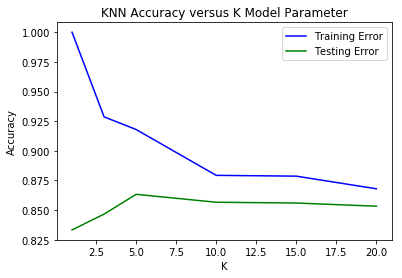

In [8]:
tracc = [item[0] for item in results]
tstacc = [item[1] for item in results]

trainAcc = plt.plot(K, tracc, '-b', label='Training Error')
testACC = plt.plot(K, tstacc, '-g', label='Testing Error')
plt.title("KNN Accuracy versus K Model Parameter")
plt.ylabel("Accuracy")
plt.xlabel("K")
plt.legend(loc=1)
plt.show(block=False)

### Contingency Tables

#### Let's look at the contingency tables

#### 1) Can you calculate the Sensitivity, Specificity, PPV, NPV? 

In [9]:
model = input("Enter Best Model: ")
best = cont[int(model)]
knn_ct = pd.crosstab(best[1], best[0], margins=True)
knn_ct.columns = ["Other", "PNA", "Total"]
knn_ct.index = ["Other", "PNA", "Total"]
print()
print("KNN")
print(knn_ct)
print()


Enter Best Model: 1

KNN
       Other  PNA  Total
Other    902  132   1034
PNA       98  368    466
Total   1000  500   1500



### Evaluation Statistics

#### We will calculate some test statistics for our classifiers

In [10]:
Sens = knn_ct.iloc[1][1]/knn_ct.iloc[2][1]
Spec = knn_ct.iloc[0][0]/knn_ct.iloc[2][0]
PPV = knn_ct.iloc[1][1]/knn_ct.iloc[1][2]
NPV = knn_ct.iloc[0][0]/knn_ct.iloc[0][2]
ACC = (knn_ct.iloc[0][0] + knn_ct.iloc[1][1]) / knn_ct.iloc[2][2]
print("KNN: Sensitivity: %.5f Specificity: %.5f PPV: %.5f NPV: %.5f Accuracy: %.5f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

KNN: Sensitivity: 0.73600 Specificity: 0.90200 PPV: 0.78970 NPV: 0.87234 Accuracy: 0.84667


### ROC Curve

#### 1) So which classifier do you think is better?

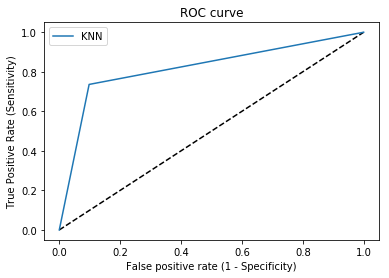

AUC =  0.819


In [11]:
knn_fpr, knn_tpr, knn_thresholds = roc_curve(best[0], best[1], pos_label=1)
roc_auc = auc(knn_fpr, knn_tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(knn_fpr, knn_tpr, label='KNN')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)